# Analysis of the model parameters estimate III
Here we show the contribution of individual components in the MEM using heatmaps. 

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy

# 🔥 Fix: Add utils/ directory where vb_stan.py and sub_fun.py are located
sys.path.append("../utils")  # Ensure utils is in module search path

# ✅ Import vb_stan and sub_fun
try:
    import vb_stan as vbfun
    import sub_fun as sf
    print("✅ Successfully imported vb_stan and sub_fun!")
except ModuleNotFoundError as e:
    print(f"❌ Error: {e}")

# Ensure analysis folder exists
figfol = '../results/results_op/plots/'

if not os.path.exists(figfol):
    os.makedirs(figfol)
    print(f"✅ Created folder: {figfol}")
else:
    print(f"📂 Folder already exists: {figfol}")

# ✅ Fix: Execute data_file.py (after setting correct paths)
try:
    exec(open('./data_file.py').read())  # Execute the script
    print("✅ Successfully executed data_file.py")
except Exception as e:
    print(f"❌ Error executing data_file.py: {e}")

# Update plot settings
plt.rcParams.update(plt.rcParamsDefault)
params = {
    'legend.fontsize': 12,
    'font.weight': 'bold',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'figure.dpi': 200,
    'ytick.labelsize': 12
}
plt.rcParams.update(params)

%matplotlib inline


✅ Successfully imported vb_stan and sub_fun!
📂 Folder already exists: ../results/results_op/plots/


/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


✅ Successfully executed data_file.py


In [3]:
import glob
import pickle
import os

# Define folder path
folname = '../src/'
fname_best = '30_model_nb_cvtest.pkl'

# Load fitted model output
with open(os.path.join(folname, fname_best), 'rb') as f:
    [holdout_mask, llpd, n_test, l, m_seed, sp_mean, sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(f)

# Construct filenames using uid and m_seed
fname_ot = os.path.join(folname, f"{uid}_model_nb.pkl")
sample_fname = os.path.join(folname, f"{uid}_sample_model_nb_cvtest.pkl")

# Load results
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)

# Load sample model output
with open(sample_fname, 'rb') as f:
    [Yte_sample, Yte_cv] = pickle.load(f)


parma_mean  = dict(vbfun.vb_extract_mean(results))

../utils/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [4]:
## Get mean estimate of the MEM  
muest = np.zeros((n,q))
muest1 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        muest[i,j] =  parma_mean['C0'][j] + \
            np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
            np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
            np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
            #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
        if Yi[i,j] == 1:
            temp = copy.copy(Yi[i,:]);temp[j] = 0;
            muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
            muest[i,j] = muest[i,j] + muest1[i,j];
        muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])


In [7]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('../data/data_op/species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('../data/data_op/species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
#import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var

tax_nameN = tax_name[['Label','ECR']]
tax_nameN['val'] = c_ord
tax_nameN.iloc[c_ord,2] = range(Y.shape[1])
# ## Add cluster index in the 
comunity2 = pickle.load(open('ERC_community.pkl', 'rb'))
tem = tax_nameN['Label'].map(comunity2) + 1
clust_col = np.array(['red','blue','green','yellow','grey'])[tem.values-1]
tax_nameN['Cluster'] = clust_col
tax_nameN['COMIND'] = tem
tax_nameN = tax_nameN.sort_values(["COMIND", "val"], ascending = (True, False))
v_indexN = [0]+list(np.where(np.diff(tax_nameN.COMIND.values) > 0)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)
# tax_namex = copy.copy(tax_nameN)
# tax_namex['ERC'] = tax_namex['ECR'].map(species_col_dict)

/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/dss/dsshome1/09/ra64nef3/.conda/envs/vim/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


FileNotFoundError: [Errno 2] No such file or directory: 'ERC_community.pkl'

In [12]:
import pandas as pd
import numpy as np

# Load species taxonomy data
tax_name = pd.read_csv('../data/data_op/species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]  # Remove first row if needed
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index=False)

# Process taxonomy levels
temx = tax_name.iloc[:, :8].replace(np.nan, '')
species_name = []

# Add taxonomy identifier for species names
for i in range(temx.shape[0]):
    a = temx.iloc[i, :].values
    for j in range(len(a)-1, -1, -1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower() + '_' + a[j])
            break

species_name = np.array(species_name)
tax_name['Name'] = species_name

# Compute abundance for each species
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan, 'Empty')

# Load additional annotations
tem = pd.read_csv('../data/data_op/species_tax_anot.amended.csv').iloc[:, [1, 12]]
tax_name = tax_name.merge(tem, on='Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

# **Clustering Based on ECR Instead of ERC_community.pkl**
ecr_categories = tax_name['ECR'].unique()
ecr_mapping = {category: i+1 for i, category in enumerate(ecr_categories)}

# Assign cluster index based on ECR categories
tax_name['COMIND'] = tax_name['ECR'].map(ecr_mapping)

# Assign colors based on clusters (Dynamic color mapping)
color_list = ['red', 'blue', 'green', 'yellow', 'grey', 'purple', 'orange', 'pink']
clust_col = np.array([color_list[i % len(color_list)] for i in tax_name['COMIND'] - 1])
tax_name['Cluster'] = clust_col

# **Sorting based on cluster indices**
tax_nameN = tax_name[['Label', 'ECR', 'COMIND', 'Cluster']].copy()
tax_nameN['val'] = c_ord  # Assuming `c_ord` exists
tax_nameN.loc[tax_nameN.index[c_ord], 'val'] = range(Y.shape[1])# Fix ordering
tax_nameN = tax_nameN.sort_values(["COMIND", "val"], ascending=(True, False))

# **Create cluster indices for visualization**
v_indexN = [0] + list(np.where(np.diff(tax_nameN.COMIND.values) > 0)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)

# ✅ **No more dependency on ERC_community.pkl**


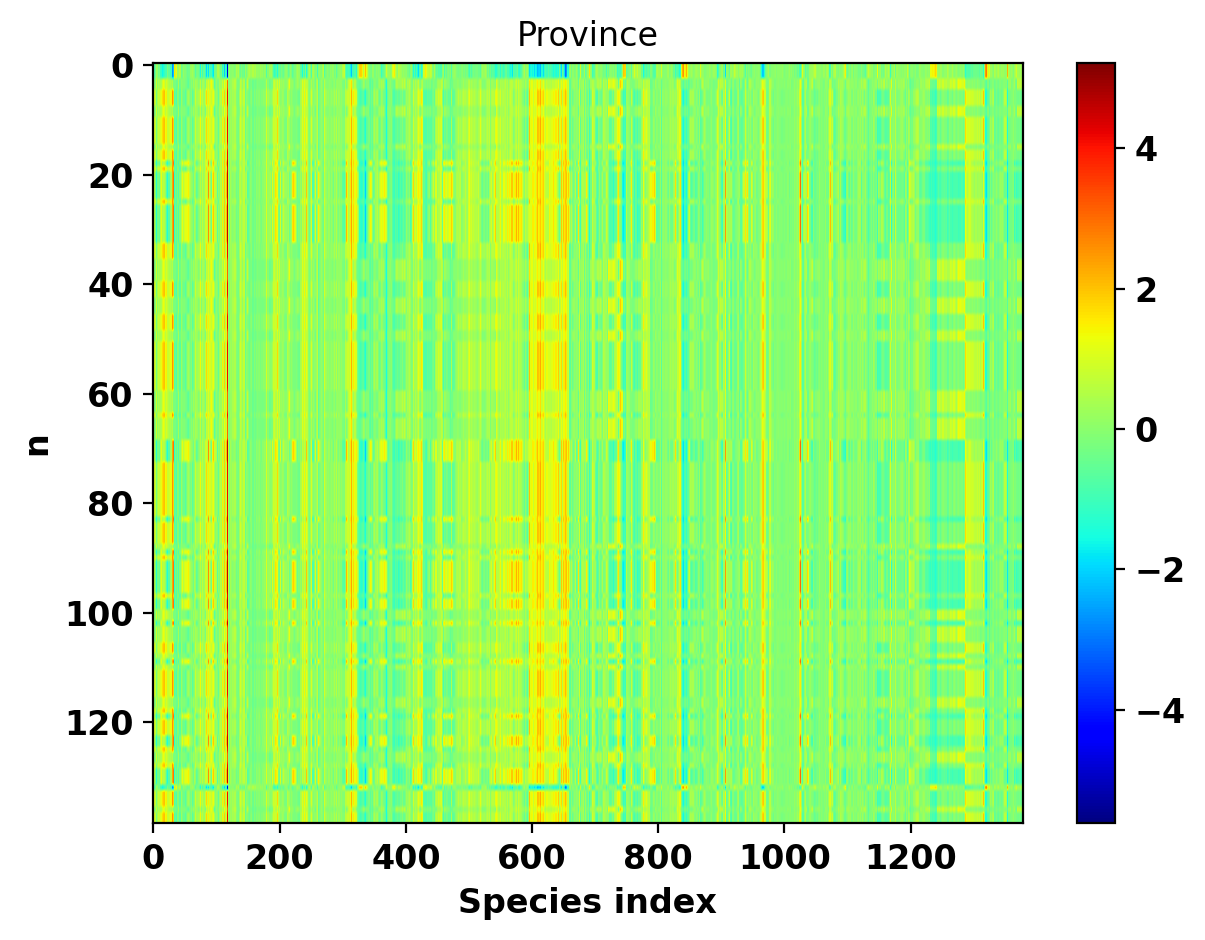

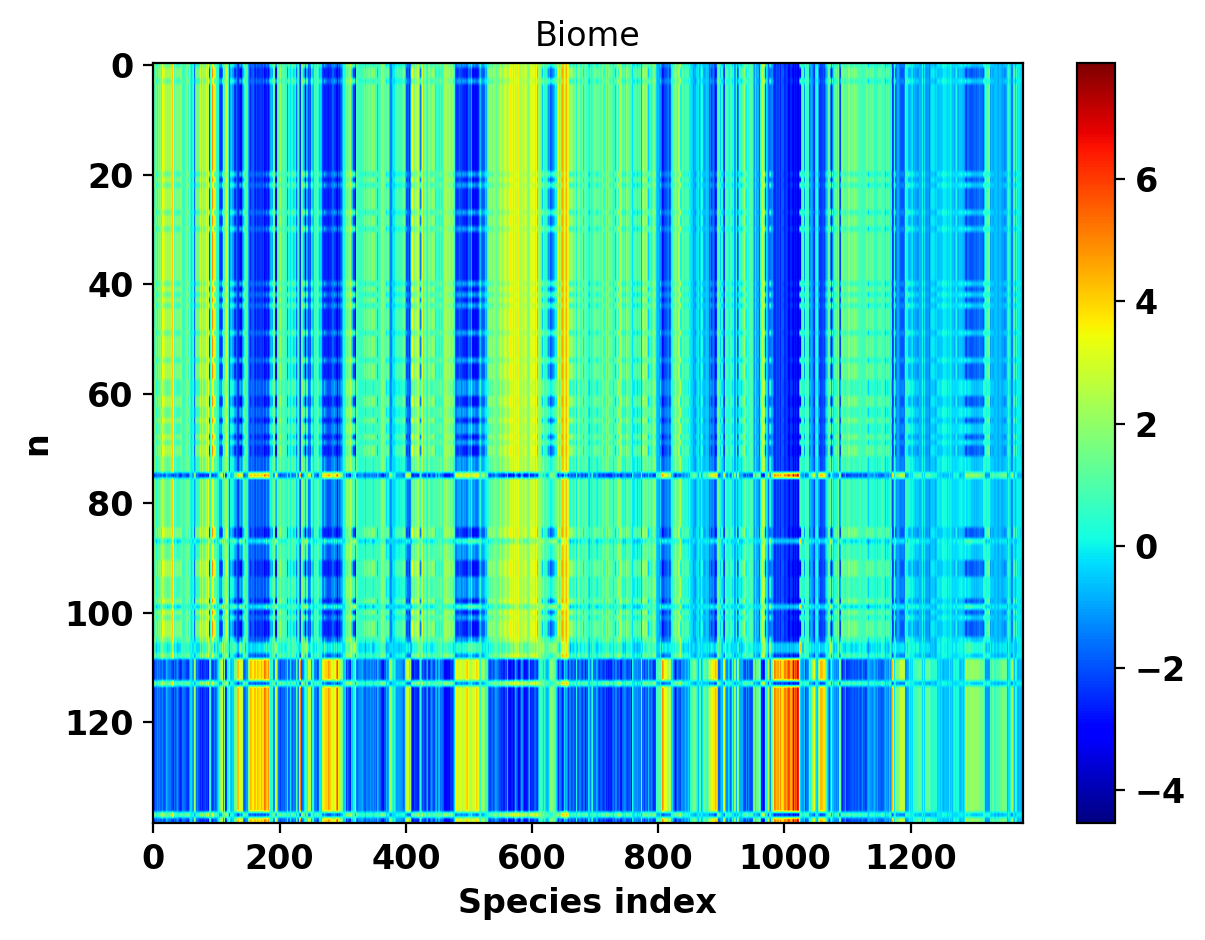

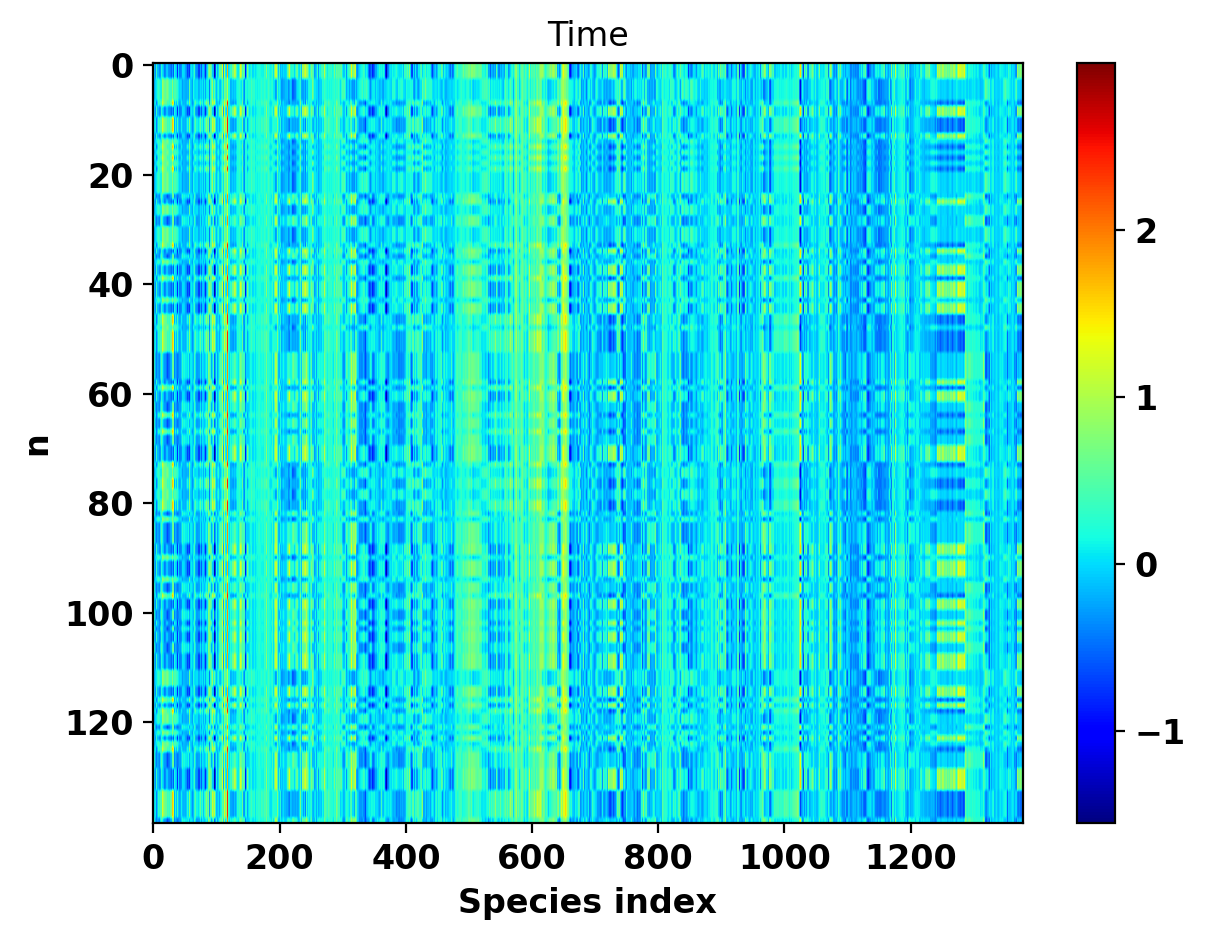

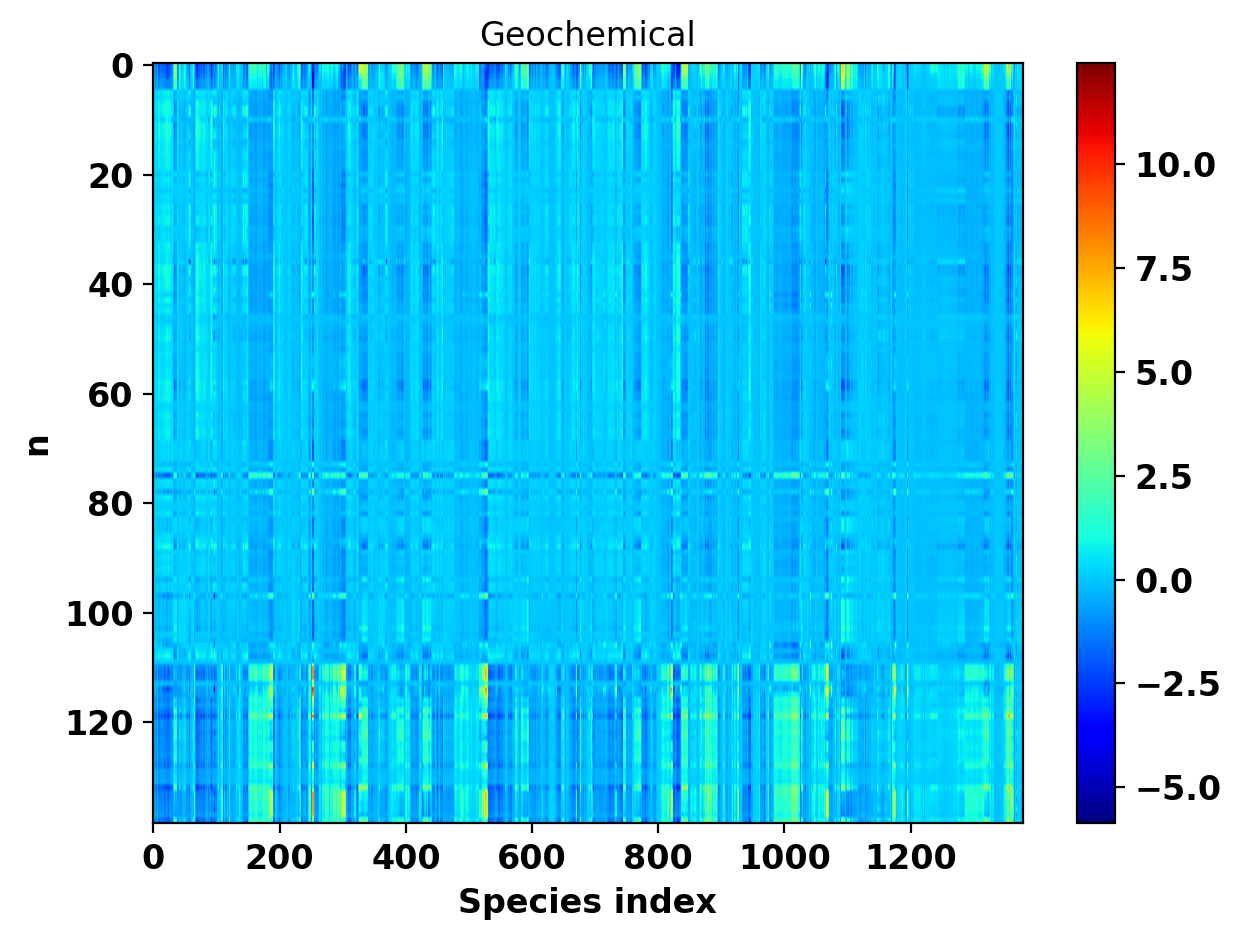

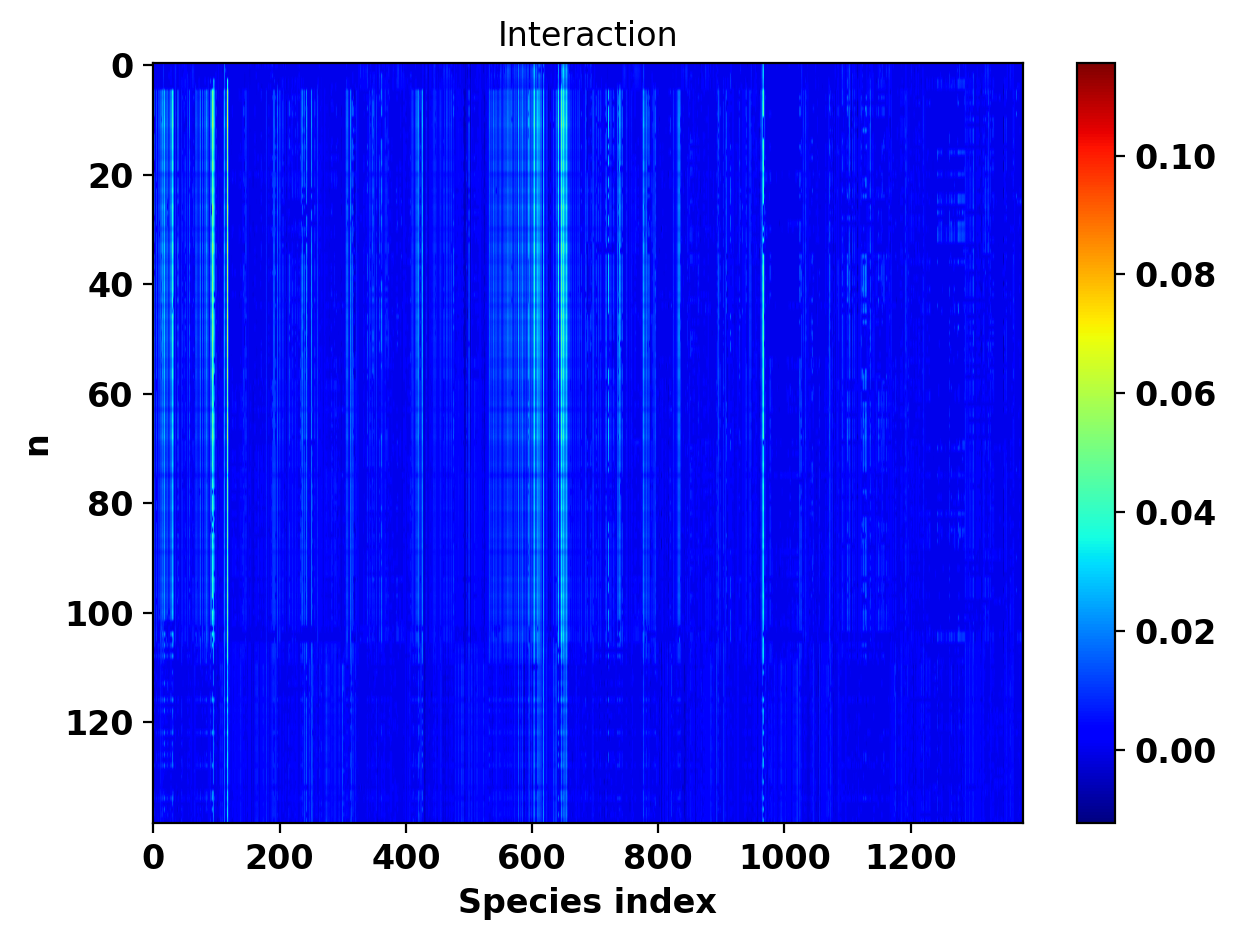

In [13]:
## Contributions of the components of the model 
from matplotlib.backends.backend_pdf import PdfPages
fnamex = figfol + 'fixed_effect.pdf'
pp = PdfPages(fnamex)
col_ulim = np.log((Y+1).max())

## Region effect: contribution of the spatio temporal locations in the ocean 
tem = np.matmul(S,np.matmul(parma_mean['A_s'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Province')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)



## Biome effect: contribution of the Biome/depth 
tem = np.matmul(B,np.matmul(parma_mean['A_b'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Biome')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Quarter effect: contribution of the time of the data collection 
tem = np.matmul(Q,np.matmul(parma_mean['A_m'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Time')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Geochemical component effect: contribution of the geochemical covariates 
tem = np.matmul(X,parma_mean['C_geo'].transpose())
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Geochemical')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Interaction component effect: contribution of the species-species interaction term 
tem = muest1;
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Interaction')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


pp.close()